# Assignment 6

### Set up connection to WRDS...

In [2]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import wrds
import statsmodels.api as sm
sns.set(rc={'figure.figsize':(15,8)})
db=wrds.Connection(wrds_username='matteo_ferrazzi')
#db.create_pgpass_file()


Loading library list...
Done


### Download and format data

In [3]:
#---------------------------------------------
# Risk Free Rate 
#---------------------------------------------
Rf=db.raw_sql("""select  mcaldt,tmytm 
           from crsp.tfz_mth_rf            
            where kytreasnox = 2000001 
           and mcaldt>='1980-01-01'
            and mcaldt<='2022-12-31'""", date_cols=['mcaldt'])
Rf['tmytm']=np.exp(Rf['tmytm']/12/100)-1
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})

In [4]:
#---------------------------------------------
# Value Weighted Index Returns
#---------------------------------------------
Rm=db.raw_sql("""select  date,vwretd from crsp.msi 
                where date>='1980-01-01' and date<='2022-12-31'
                """,date_cols=['date'])
Rm = Rm.rename(columns={'vwretd':'Rm'})




In [5]:
#---------------------------------------------
# Stock Returns 
#---------------------------------------------

stock_data = db.raw_sql("""
                    select a.permno, a.date, a.ret, a.shrout, a.prc, b.siccd 
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1980' and '12/31/2022'
                      """, date_cols=['date']) 
stock_data = stock_data.rename(columns={'ret':'Rn'})
# Restrict to SP500 
SP500_constituents = db.get_table(library='crsp', table='msp500list')
sp500 = pd.merge(SP500_constituents, stock_data,on=['permno'], how='left')
sp500['ending'] = sp500['ending'].fillna(sp500.date.max())
sp500 = sp500[(sp500.date >= sp500.start) & (sp500.date <= sp500.ending)].copy()

In [6]:
#---------------------------------------------
# Industry Definitions  and Returns 
#---------------------------------------------
Industry_Returns = pd.read_csv('12_Industry_Portfolios.txt', delimiter= '\s+')
Industry_Definitions = pd.read_csv('48_Industries.csv')
Industry_Definitions = Industry_Definitions.rename(columns={'SIC':'siccd'})
Industries = Industry_Returns.columns.tolist()
Industry_Names = pd.DataFrame(Industries,index=np.arange(1,13)).reset_index()
Industry_Names.columns=['Industry','Name']
Industry_Returns = Industry_Returns.reset_index().rename(columns = {'index':'dateM'})
Industry_Returns['dateM'] = pd.to_datetime(Industry_Returns['dateM'], format='%Y%m', errors='coerce')

Industry_Returns[['NoDur','Durbl','Manuf','Enrgy','Chems','BusEq','Telcm','Utils','Shops','Hlth','Money','Other']]=Industry_Returns[['NoDur','Durbl','Manuf','Enrgy','Chems','BusEq','Telcm','Utils','Shops','Hlth','Money','Other']]/100

### Merge different data-sources

In [7]:
#---------------------------------------------
# Merge Data 
#---------------------------------------------
data = pd.merge(sp500, Rf, on=['date'], how='left')
data = pd.merge(data, Rm, on=['date'], how='left')
data = pd.merge(data, Industry_Definitions[['siccd','FF_12']],on=['siccd'], how='left')
data['dateM'] = data['date'].astype('datetime64[M]')
data = pd.merge(data, Industry_Returns,on=['dateM'], how='left')
#data = pd.merge(data, ESG_data, on=['dateM'], how='left')

#---------------------------------------------
# Define Variables and drop obs
#---------------------------------------------
data = data.sort_values(['permno','date'])
data['mcap'] = np.abs(data['prc'])*data['shrout']
data['mcap_l'] = data.groupby(['permno'])['mcap'].shift(1)
data['Rn_f'] = data.groupby(['permno'])['Rn'].shift(-1)
data['const'] = 1
data['Rn_e'] = data['Rn']-data['rf']
data['Rm_e'] = data['Rm']-data['rf']
data['w_m'] = data['mcap_l']/data.groupby(['date'])['mcap_l'].transform('sum')
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e','FF_12']).copy()

In [8]:
data

,permno,start,ending,date,Rn,shrout,prc,siccd,rf,Rm,...,Hlth,Money,Other,mcap,mcap_l,Rn_f,const,Rn_e,Rm_e,w_m
1,10006.0,1957-03-01,1984-07-18,1980-02-29,-0.058795,8859.0,38.500000,3743.0,0.011412,0.001015,...,-0.0463,-0.0502,-0.0159,3.410715e+05,3.676485e+05,-0.172078,1,-0.070207,-0.010397,0.000491
2,10006.0,1957-03-01,1984-07-18,1980-03-31,-0.172078,8859.0,31.875000,3743.0,0.012621,-0.120224,...,-0.0284,-0.0890,-0.1565,2.823806e+05,3.410715e+05,-0.027451,1,-0.184699,-0.132845,0.000456
3,10006.0,1957-03-01,1984-07-18,1980-04-30,-0.027451,8859.0,31.000000,3743.0,0.007728,0.052287,...,0.0428,0.0683,0.0525,2.746290e+05,2.823806e+05,0.084677,1,-0.035179,0.044559,0.000421
4,10006.0,1957-03-01,1984-07-18,1980-05-30,0.084677,8859.0,33.000000,3743.0,0.006003,0.060090,...,0.0696,0.0788,0.0838,2.923470e+05,2.746290e+05,-0.007576,1,0.078674,0.054088,0.000391
5,10006.0,1957-03-01,1984-07-18,1980-06-30,-0.007576,8889.0,32.750000,3743.0,0.005181,0.037714,...,0.0021,0.0490,0.0535,2.911148e+05,2.923470e+05,0.091603,1,-0.012757,0.032533,0.000397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258437,93436.0,2020-12-21,2022-12-30,2022-08-31,-0.072489,3133470.0,275.609985,9999.0,0.001964,-0.036240,...,-0.0507,-0.0224,-0.0394,8.636156e+08,9.311106e+08,-0.037589,1,-0.074453,-0.038204,0.025666
258438,93436.0,2020-12-21,2022-12-30,2022-09-30,-0.037589,3158000.0,265.250000,9999.0,0.002274,-0.091324,...,-0.0191,-0.0773,-0.0827,8.376595e+08,8.636156e+08,-0.142168,1,-0.039863,-0.093598,0.024908
258439,93436.0,2020-12-21,2022-12-30,2022-10-31,-0.142168,3157752.0,227.539993,9999.0,0.002885,0.077403,...,0.0884,0.1280,0.0984,7.185149e+08,8.376595e+08,-0.144326,1,-0.145053,0.074518,0.026645
258440,93436.0,2020-12-21,2022-12-30,2022-11-30,-0.144326,3157752.0,194.699997,9999.0,0.003326,0.052365,...,0.0546,0.0474,0.0784,6.148143e+08,7.185149e+08,-0.367334,1,-0.147652,0.049040,0.021199


# Construct Momentum Strategy

Cumulative 12 month past return for each stock:

In [9]:
cum_ann_ret=data.groupby('permno')['Rn'].rolling(12).apply(lambda x : np.prod((1+x))-1)

In [10]:
data['cum_ann_ret']=cum_ann_ret.values

In [11]:
data

,permno,start,ending,date,Rn,shrout,prc,siccd,rf,Rm,...,Money,Other,mcap,mcap_l,Rn_f,const,Rn_e,Rm_e,w_m,cum_ann_ret
1,10006.0,1957-03-01,1984-07-18,1980-02-29,-0.058795,8859.0,38.500000,3743.0,0.011412,0.001015,...,-0.0502,-0.0159,3.410715e+05,3.676485e+05,-0.172078,1,-0.070207,-0.010397,0.000491,NaN
2,10006.0,1957-03-01,1984-07-18,1980-03-31,-0.172078,8859.0,31.875000,3743.0,0.012621,-0.120224,...,-0.0890,-0.1565,2.823806e+05,3.410715e+05,-0.027451,1,-0.184699,-0.132845,0.000456,NaN
3,10006.0,1957-03-01,1984-07-18,1980-04-30,-0.027451,8859.0,31.000000,3743.0,0.007728,0.052287,...,0.0683,0.0525,2.746290e+05,2.823806e+05,0.084677,1,-0.035179,0.044559,0.000421,NaN
4,10006.0,1957-03-01,1984-07-18,1980-05-30,0.084677,8859.0,33.000000,3743.0,0.006003,0.060090,...,0.0788,0.0838,2.923470e+05,2.746290e+05,-0.007576,1,0.078674,0.054088,0.000391,NaN
5,10006.0,1957-03-01,1984-07-18,1980-06-30,-0.007576,8889.0,32.750000,3743.0,0.005181,0.037714,...,0.0490,0.0535,2.911148e+05,2.923470e+05,0.091603,1,-0.012757,0.032533,0.000397,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258437,93436.0,2020-12-21,2022-12-30,2022-08-31,-0.072489,3133470.0,275.609985,9999.0,0.001964,-0.036240,...,-0.0224,-0.0394,8.636156e+08,9.311106e+08,-0.037589,1,-0.074453,-0.038204,0.025666,0.123838
258438,93436.0,2020-12-21,2022-12-30,2022-09-30,-0.037589,3158000.0,265.250000,9999.0,0.002274,-0.091324,...,-0.0773,-0.0827,8.376595e+08,8.636156e+08,-0.142168,1,-0.039863,-0.093598,0.024908,0.026139
258439,93436.0,2020-12-21,2022-12-30,2022-10-31,-0.142168,3157752.0,227.539993,9999.0,0.002885,0.077403,...,0.1280,0.0984,7.185149e+08,8.376595e+08,-0.144326,1,-0.145053,0.074518,0.026645,-0.387235
258440,93436.0,2020-12-21,2022-12-30,2022-11-30,-0.144326,3157752.0,194.699997,9999.0,0.003326,0.052365,...,0.0474,0.0784,6.148143e+08,7.185149e+08,-0.367334,1,-0.147652,0.049040,0.021199,-0.489762


In [12]:
data1=data.copy()
data1=data1.dropna(subset=['cum_ann_ret'])
labels = ["1st", "2nd", "3rd", "4th", "5th", "6th", "7th", "8th", "9th", "10th"]
data1["quantiles"] = data1.groupby(['date'])['cum_ann_ret'].transform(lambda x: pd.qcut(x,10,labels=labels)) 

In [13]:
data1

,permno,start,ending,date,Rn,shrout,prc,siccd,rf,Rm,...,Other,mcap,mcap_l,Rn_f,const,Rn_e,Rm_e,w_m,cum_ann_ret,quantiles
12,10006.0,1957-03-01,1984-07-18,1981-01-30,0.108696,9009.0,51.000000,3743.0,0.011667,-0.040085,...,-0.0258,4.594590e+05,4.144140e+05,-0.022059,1,0.097029,-0.051752,0.000451,0.309270,8th
13,10006.0,1957-03-01,1984-07-18,1981-02-27,-0.022059,9009.0,49.875000,3743.0,0.011762,0.015519,...,0.0142,4.493239e+05,4.594590e+05,-0.005013,1,-0.033821,0.003757,0.000523,0.360373,7th
14,10006.0,1957-03-01,1984-07-18,1981-03-31,-0.005013,9009.0,49.000000,3743.0,0.010906,0.046183,...,0.1011,4.414410e+05,4.493239e+05,-0.066327,1,-0.015919,0.035277,0.000504,0.634881,8th
15,10006.0,1957-03-01,1984-07-18,1981-04-30,-0.066327,9009.0,45.750000,3743.0,0.011583,-0.011266,...,0.0131,4.121618e+05,4.414410e+05,0.066995,1,-0.077909,-0.022849,0.000479,0.569530,7th
16,10006.0,1957-03-01,1984-07-18,1981-05-29,0.066995,9009.0,48.125000,3743.0,0.013550,0.013546,...,0.0223,4.335581e+05,4.121618e+05,-0.075325,1,0.053445,-0.000003,0.000456,0.543943,8th
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258437,93436.0,2020-12-21,2022-12-30,2022-08-31,-0.072489,3133470.0,275.609985,9999.0,0.001964,-0.036240,...,-0.0394,8.636156e+08,9.311106e+08,-0.037589,1,-0.074453,-0.038204,0.025666,0.123838,9th
258438,93436.0,2020-12-21,2022-12-30,2022-09-30,-0.037589,3158000.0,265.250000,9999.0,0.002274,-0.091324,...,-0.0827,8.376595e+08,8.636156e+08,-0.142168,1,-0.039863,-0.093598,0.024908,0.026139,8th
258439,93436.0,2020-12-21,2022-12-30,2022-10-31,-0.142168,3157752.0,227.539993,9999.0,0.002885,0.077403,...,0.0984,7.185149e+08,8.376595e+08,-0.144326,1,-0.145053,0.074518,0.026645,-0.387235,2nd
258440,93436.0,2020-12-21,2022-12-30,2022-11-30,-0.144326,3157752.0,194.699997,9999.0,0.003326,0.052365,...,0.0784,6.148143e+08,7.185149e+08,-0.367334,1,-0.147652,0.049040,0.021199,-0.489762,1st


Momentum Decile Weights (market-cap weighted)

In [14]:
data1['wm_quant'] = data1['mcap_l']/data1.groupby(['date','quantiles'])['mcap_l'].transform('sum')
data1['wm_quant'][(data1['quantiles']!='1st') & (data1['quantiles']!='10th')]=0
data1['wm_quant'][data1['quantiles']=='1st']=-data1['wm_quant'][data1['quantiles']=='1st']
data1['mom_ret_vw'] = data1['Rn']*data1['wm_quant']

/var/folders/xm/v8rw_rk978q4m456yhl9rn_c0000gn/T/ipykernel_67435/3167916023.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['wm_quant'][(data1['quantiles']!='1st') & (data1['quantiles']!='10th')]=0
/var/folders/xm/v8rw_rk978q4m456yhl9rn_c0000gn/T/ipykernel_67435/3167916023.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['wm_quant'][data1['quantiles']=='1st']=-data1['wm_quant'][data1['quantiles']=='1st']


In [15]:
data1

,permno,start,ending,date,Rn,shrout,prc,siccd,rf,Rm,...,mcap_l,Rn_f,const,Rn_e,Rm_e,w_m,cum_ann_ret,quantiles,wm_quant,mom_ret_vw
12,10006.0,1957-03-01,1984-07-18,1981-01-30,0.108696,9009.0,51.000000,3743.0,0.011667,-0.040085,...,4.144140e+05,-0.022059,1,0.097029,-0.051752,0.000451,0.309270,8th,0.000000,0.000000
13,10006.0,1957-03-01,1984-07-18,1981-02-27,-0.022059,9009.0,49.875000,3743.0,0.011762,0.015519,...,4.594590e+05,-0.005013,1,-0.033821,0.003757,0.000523,0.360373,7th,0.000000,-0.000000
14,10006.0,1957-03-01,1984-07-18,1981-03-31,-0.005013,9009.0,49.000000,3743.0,0.010906,0.046183,...,4.493239e+05,-0.066327,1,-0.015919,0.035277,0.000504,0.634881,8th,0.000000,-0.000000
15,10006.0,1957-03-01,1984-07-18,1981-04-30,-0.066327,9009.0,45.750000,3743.0,0.011583,-0.011266,...,4.414410e+05,0.066995,1,-0.077909,-0.022849,0.000479,0.569530,7th,0.000000,-0.000000
16,10006.0,1957-03-01,1984-07-18,1981-05-29,0.066995,9009.0,48.125000,3743.0,0.013550,0.013546,...,4.121618e+05,-0.075325,1,0.053445,-0.000003,0.000456,0.543943,8th,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258437,93436.0,2020-12-21,2022-12-30,2022-08-31,-0.072489,3133470.0,275.609985,9999.0,0.001964,-0.036240,...,9.311106e+08,-0.037589,1,-0.074453,-0.038204,0.025666,0.123838,9th,0.000000,-0.000000
258438,93436.0,2020-12-21,2022-12-30,2022-09-30,-0.037589,3158000.0,265.250000,9999.0,0.002274,-0.091324,...,8.636156e+08,-0.142168,1,-0.039863,-0.093598,0.024908,0.026139,8th,0.000000,-0.000000
258439,93436.0,2020-12-21,2022-12-30,2022-10-31,-0.142168,3157752.0,227.539993,9999.0,0.002885,0.077403,...,8.376595e+08,-0.144326,1,-0.145053,0.074518,0.026645,-0.387235,2nd,0.000000,-0.000000
258440,93436.0,2020-12-21,2022-12-30,2022-11-30,-0.144326,3157752.0,194.699997,9999.0,0.003326,0.052365,...,7.185149e+08,-0.367334,1,-0.147652,0.049040,0.021199,-0.489762,1st,-0.188779,0.027246


Momentum Returns since 1980

In [16]:
mom_ret=data1.groupby(['date'])['mom_ret_vw'].sum()

In [17]:
mom_ret

date
1981-01-30   -0.045755
1981-02-27    0.118042
1981-03-31    0.159849
1981-04-30    0.075368
1981-05-29    0.142505
                ...   
2022-08-31    0.064439
2022-09-30    0.117360
2022-10-31    0.167578
2022-11-30    0.015128
2022-12-30    0.130345
Name: mom_ret_vw, Length: 504, dtype: float64

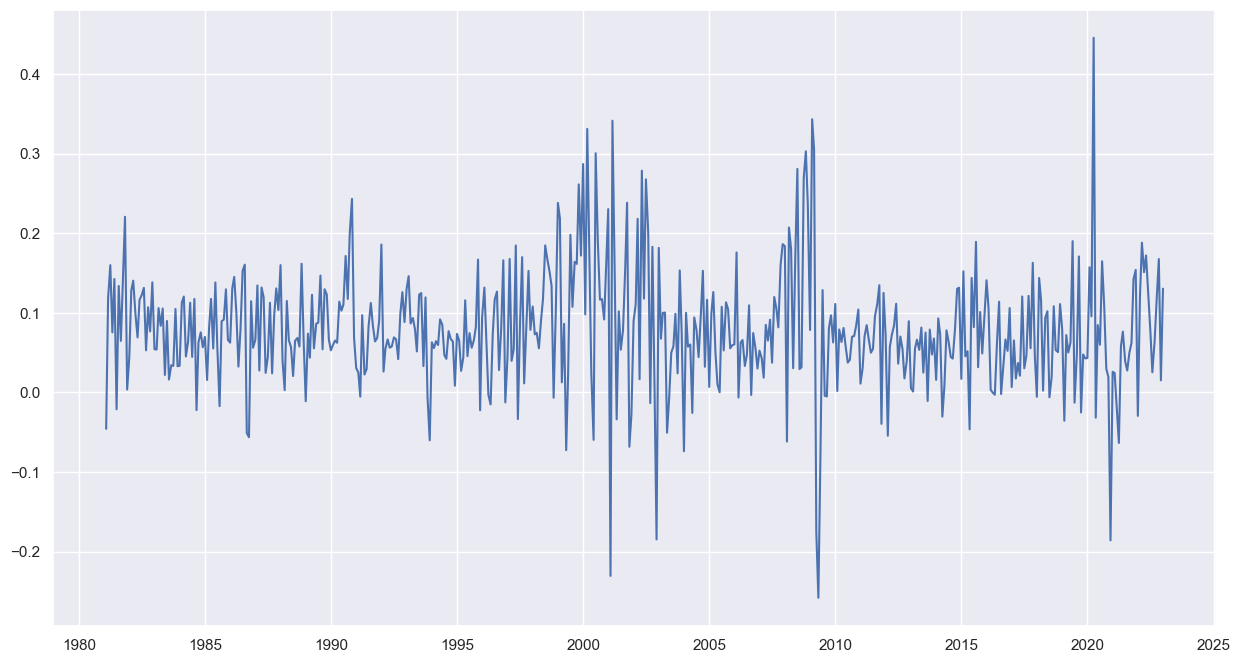

In [18]:
plt.plot(mom_ret)
plt.show()

In [19]:
mu_mom=mom_ret.mean()
std_mom=mom_ret.std()
mu_rf=Rf.mean(numeric_only=True)
mu_rf=mu_rf.values[0]
SR_mom=(mu_mom-mu_rf)/std_mom
SR_mom

1.0000071057967783

In [20]:
mom_ret=pd.DataFrame(mom_ret)

In [21]:
mom_ret

,mom_ret_vw
date,
1981-01-30,-0.045755
1981-02-27,0.118042
1981-03-31,0.159849
1981-04-30,0.075368
1981-05-29,0.142505
...,...
2022-08-31,0.064439
2022-09-30,0.117360
2022-10-31,0.167578


In [22]:
mom_ret.rename(columns={'mom_ret_vw':"mom_ret"},inplace=True)

## Observable Factors

In [23]:
Rf['date'] = pd.to_datetime(Rf['date'], format='%Y%m', errors='coerce')

In [24]:
Rm['date'] = pd.to_datetime(Rm['date'], format='%Y%m', errors='coerce')

In [25]:
Industry_Returns_new=Industry_Returns[Industry_Returns['dateM']>='1980-02-01']

In [26]:
Industry_Returns_new['dateM']=Rf['date'].values

/var/folders/xm/v8rw_rk978q4m456yhl9rn_c0000gn/T/ipykernel_67435/1176066160.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Industry_Returns_new['dateM']=Rf['date'].values


In [27]:
Industry_Returns_new.rename(columns={'dateM':"date"},inplace=True)

/var/folders/xm/v8rw_rk978q4m456yhl9rn_c0000gn/T/ipykernel_67435/2518821547.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Industry_Returns_new.rename(columns={'dateM':"date"},inplace=True)


In [28]:
Industry_Returns_new

,date,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
643,1980-01-31,-0.0480,-0.0631,-0.0275,0.1258,-0.0184,-0.0359,-0.0148,-0.0336,-0.0479,-0.0463,-0.0502,-0.0159
644,1980-02-29,-0.0816,-0.0874,-0.1236,-0.1779,-0.0999,-0.1266,-0.0264,-0.0667,-0.0876,-0.0284,-0.0890,-0.1565
645,1980-03-31,0.0652,-0.0191,0.0237,0.0685,0.0558,0.0056,0.0730,0.1196,0.0336,0.0428,0.0683,0.0525
646,1980-04-30,0.0788,0.0431,0.0563,0.0405,0.0779,0.0479,0.0502,0.0461,0.1067,0.0696,0.0788,0.0838
647,1980-05-30,0.0299,0.0279,0.0281,0.0581,0.0105,0.0308,-0.0058,0.0454,0.0237,0.0021,0.0490,0.0535
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154,2022-08-31,-0.0832,-0.0668,-0.1188,-0.0912,-0.1075,-0.1140,-0.1394,-0.1165,-0.0761,-0.0191,-0.0773,-0.0827
1155,2022-09-30,0.0994,-0.0627,0.1482,0.2360,0.0692,0.0480,0.1094,0.0350,0.0430,0.0884,0.1280,0.0984
1156,2022-10-31,0.0527,-0.0757,0.0862,0.0097,0.0990,0.0526,0.0232,0.0682,0.0386,0.0546,0.0474,0.0784
1157,2022-11-30,-0.0267,-0.2747,-0.0243,-0.0416,-0.0220,-0.0791,-0.0676,-0.0115,-0.0796,-0.0173,-0.0549,-0.0491


In [29]:
data_reg=pd.merge(Rf,Rm,left_on='date',right_on='date')
data_reg=pd.merge(data_reg,Industry_Returns_new,left_on='date',right_on='date')
data_reg=pd.merge(data_reg,mom_ret,how='inner',left_on='date',right_on='date')

In [30]:
data_reg

,date,rf,Rm,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other,mom_ret
0,1981-01-30,0.011667,-0.040085,0.0249,0.0641,0.0427,-0.0047,0.0472,0.0034,0.0216,-0.0132,0.0264,0.0185,0.0195,0.0142,-0.045755
1,1981-02-27,0.011762,0.015519,0.0693,0.0707,0.0729,-0.0249,0.0242,0.0507,0.0116,0.0296,0.1272,0.0587,0.0687,0.1011,0.118042
2,1981-03-31,0.010906,0.046183,0.0115,0.0181,-0.0076,-0.0745,-0.0119,-0.0003,0.0621,-0.0258,0.0302,0.0300,0.0064,0.0131,0.159849
3,1981-04-30,0.011583,-0.011266,0.0264,0.0288,-0.0009,-0.0401,-0.0108,0.0431,0.0714,0.0195,0.0282,0.0347,0.0277,0.0223,0.075368
4,1981-05-29,0.013550,0.013546,-0.0020,-0.0421,-0.0246,0.0475,0.0169,-0.0668,-0.0191,0.0345,-0.0143,-0.0558,0.0172,-0.0386,0.142505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,2022-08-31,0.001964,-0.036240,-0.0832,-0.0668,-0.1188,-0.0912,-0.1075,-0.1140,-0.1394,-0.1165,-0.0761,-0.0191,-0.0773,-0.0827,0.064439
500,2022-09-30,0.002274,-0.091324,0.0994,-0.0627,0.1482,0.2360,0.0692,0.0480,0.1094,0.0350,0.0430,0.0884,0.1280,0.0984,0.117360
501,2022-10-31,0.002885,0.077403,0.0527,-0.0757,0.0862,0.0097,0.0990,0.0526,0.0232,0.0682,0.0386,0.0546,0.0474,0.0784,0.167578
502,2022-11-30,0.003326,0.052365,-0.0267,-0.2747,-0.0243,-0.0416,-0.0220,-0.0791,-0.0676,-0.0115,-0.0796,-0.0173,-0.0549,-0.0491,0.015128


In [31]:
data_reg['const']=1
data_reg['r_mom_e']=data_reg['mom_ret']-data_reg['rf']
data_reg['Rm_e']=data_reg['Rm']-data_reg['rf']


In [32]:
data_reg

,date,rf,Rm,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other,mom_ret,const,r_mom_e,Rm_e
0,1981-01-30,0.011667,-0.040085,0.0249,0.0641,0.0427,-0.0047,0.0472,0.0034,0.0216,-0.0132,0.0264,0.0185,0.0195,0.0142,-0.045755,1,-0.057422,-0.051752
1,1981-02-27,0.011762,0.015519,0.0693,0.0707,0.0729,-0.0249,0.0242,0.0507,0.0116,0.0296,0.1272,0.0587,0.0687,0.1011,0.118042,1,0.106280,0.003757
2,1981-03-31,0.010906,0.046183,0.0115,0.0181,-0.0076,-0.0745,-0.0119,-0.0003,0.0621,-0.0258,0.0302,0.0300,0.0064,0.0131,0.159849,1,0.148942,0.035277
3,1981-04-30,0.011583,-0.011266,0.0264,0.0288,-0.0009,-0.0401,-0.0108,0.0431,0.0714,0.0195,0.0282,0.0347,0.0277,0.0223,0.075368,1,0.063785,-0.022849
4,1981-05-29,0.013550,0.013546,-0.0020,-0.0421,-0.0246,0.0475,0.0169,-0.0668,-0.0191,0.0345,-0.0143,-0.0558,0.0172,-0.0386,0.142505,1,0.128955,-0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,2022-08-31,0.001964,-0.036240,-0.0832,-0.0668,-0.1188,-0.0912,-0.1075,-0.1140,-0.1394,-0.1165,-0.0761,-0.0191,-0.0773,-0.0827,0.064439,1,0.062474,-0.038204
500,2022-09-30,0.002274,-0.091324,0.0994,-0.0627,0.1482,0.2360,0.0692,0.0480,0.1094,0.0350,0.0430,0.0884,0.1280,0.0984,0.117360,1,0.115086,-0.093598
501,2022-10-31,0.002885,0.077403,0.0527,-0.0757,0.0862,0.0097,0.0990,0.0526,0.0232,0.0682,0.0386,0.0546,0.0474,0.0784,0.167578,1,0.164693,0.074518
502,2022-11-30,0.003326,0.052365,-0.0267,-0.2747,-0.0243,-0.0416,-0.0220,-0.0791,-0.0676,-0.0115,-0.0796,-0.0173,-0.0549,-0.0491,0.015128,1,0.011802,0.049040


In [33]:
y=data_reg['r_mom_e']
x=data_reg[['const','Rm_e','NoDur','Durbl','Manuf','Enrgy','Chems','BusEq','Telcm','Utils','Shops','Hlth','Money','Other']]
model=sm.OLS(y, x).fit()

In [34]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                r_mom_e   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     7.627
Date:                Sun, 02 Apr 2023   Prob (F-statistic):           7.91e-14
Time:                        18:17:30   Log-Likelihood:                 637.59
No. Observations:                 504   AIC:                            -1247.
Df Residuals:                     490   BIC:                            -1188.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0798      0.003     24.151      0.000       0.073       0.086
Rm_e          -0.5592      0.070     -7.972      0.000      -0.697      -0.421
NoDur         -0.3909      0.162     -2.418      0.016      -0.708      -0.073
Durbl         -0.0142      0.068     -0.211      0.833      -0.147       0.119
Manuf         -0.4235      0.182     -2.328      0.020      -0.781      -0.066
Enrgy          0.0186      0.066      0.280      0.779      -0.112       0.149
Chems          0.1552      0.152      1.022      0.307      -0.143       0.454
BusEq          0.1145      0.084      1.363      0.174      -0.051       0.280
Telcm          0.0578      0.095      0.608      0.543      -0.129       0.244
Utils          0.0280      0.102      0.276      0.783      -0.172       0.228
Shops          0.4494      0.134      3.355      0.001       0.186       0.713
Hlth          -0.1051      0.108     -0.969      0.333      -0.318       0.108
Money          0.1702      0.116      1.468      0.143      -0.058       0.398
Other         -0.1829      0.190     -0.963      0.336      -0.556       0.190
==============================================================================
Omnibus:                       30.744   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.029
Skew:                           0.322   Prob(JB):                     1.02e-15
Kurtosis:                       4.695   Cond. No.                         73.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Unobservable Factors

In [35]:
param = data1.groupby("permno").apply(lambda x:sm.OLS(x['Rn_e'], x[['const','Rm_e']]).fit().params).reset_index()

In [36]:
param.rename(columns={'Rm_e':'beta','const':'alpha'},inplace=True)

In [37]:
dum=pd.get_dummies(data1['FF_12']).rename(columns=lambda x:'dum'+str(x))

In [38]:
dum

,dum1.0,dum2.0,dum3.0,dum4.0,dum5.0,dum6.0,dum7.0,dum8.0,dum9.0,dum10.0,dum11.0,dum12.0
12,0,0,1,0,0,0,0,0,0,0,0,0
13,0,0,1,0,0,0,0,0,0,0,0,0
14,0,0,1,0,0,0,0,0,0,0,0,0
15,0,0,1,0,0,0,0,0,0,0,0,0
16,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
258437,0,0,0,0,0,0,0,0,0,0,0,1
258438,0,0,0,0,0,0,0,0,0,0,0,1
258439,0,0,0,0,0,0,0,0,0,0,0,1
258440,0,0,0,0,0,0,0,0,0,0,0,1


In [39]:
data1=pd.merge(data1,dum,right_index=True,left_index=True)

In [40]:
data1=pd.merge(data1,param,on='permno')

In [41]:
data1.columns

Index(['permno', 'start', 'ending', 'date', 'Rn', 'shrout', 'prc', 'siccd',
       'rf', 'Rm', 'FF_12', 'dateM', 'NoDur', 'Durbl', 'Manuf', 'Enrgy',
       'Chems', 'BusEq', 'Telcm', 'Utils', 'Shops', 'Hlth', 'Money', 'Other',
       'mcap', 'mcap_l', 'Rn_f', 'const', 'Rn_e', 'Rm_e', 'w_m', 'cum_ann_ret',
       'quantiles', 'wm_quant', 'mom_ret_vw', 'dum1.0', 'dum2.0', 'dum3.0',
       'dum4.0', 'dum5.0', 'dum6.0', 'dum7.0', 'dum8.0', 'dum9.0', 'dum10.0',
       'dum11.0', 'dum12.0', 'alpha', 'beta'],
      dtype='object')

In [42]:
data1

,permno,start,ending,date,Rn,shrout,prc,siccd,rf,Rm,...,dum5.0,dum6.0,dum7.0,dum8.0,dum9.0,dum10.0,dum11.0,dum12.0,alpha,beta
0,10006.0,1957-03-01,1984-07-18,1981-01-30,0.108696,9009.0,51.000000,3743.0,0.011667,-0.040085,...,0,0,0,0,0,0,0,0,0.005160,0.680035
1,10006.0,1957-03-01,1984-07-18,1981-02-27,-0.022059,9009.0,49.875000,3743.0,0.011762,0.015519,...,0,0,0,0,0,0,0,0,0.005160,0.680035
2,10006.0,1957-03-01,1984-07-18,1981-03-31,-0.005013,9009.0,49.000000,3743.0,0.010906,0.046183,...,0,0,0,0,0,0,0,0,0.005160,0.680035
3,10006.0,1957-03-01,1984-07-18,1981-04-30,-0.066327,9009.0,45.750000,3743.0,0.011583,-0.011266,...,0,0,0,0,0,0,0,0,0.005160,0.680035
4,10006.0,1957-03-01,1984-07-18,1981-05-29,0.066995,9009.0,48.125000,3743.0,0.013550,0.013546,...,0,0,0,0,0,0,0,0,0.005160,0.680035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240211,93436.0,2020-12-21,2022-12-30,2022-08-31,-0.072489,3133470.0,275.609985,9999.0,0.001964,-0.036240,...,0,0,0,0,0,0,0,1,-0.051638,1.383270
240212,93436.0,2020-12-21,2022-12-30,2022-09-30,-0.037589,3158000.0,265.250000,9999.0,0.002274,-0.091324,...,0,0,0,0,0,0,0,1,-0.051638,1.383270
240213,93436.0,2020-12-21,2022-12-30,2022-10-31,-0.142168,3157752.0,227.539993,9999.0,0.002885,0.077403,...,0,0,0,0,0,0,0,1,-0.051638,1.383270
240214,93436.0,2020-12-21,2022-12-30,2022-11-30,-0.144326,3157752.0,194.699997,9999.0,0.003326,0.052365,...,0,0,0,0,0,0,0,1,-0.051638,1.383270


In [43]:
model2=data1.groupby("date").apply(lambda x:sm.OLS(x['Rn_e'], x[['beta','dum1.0', 'dum2.0', 'dum3.0', 'dum4.0', 'dum5.0', 'dum6.0', 'dum7.0',
       'dum8.0', 'dum9.0', 'dum10.0', 'dum11.0', 'dum12.0']]).fit().params).reset_index()

In [44]:
model2

,date,beta,dum1.0,dum2.0,dum3.0,dum4.0,dum5.0,dum6.0,dum7.0,dum8.0,dum9.0,dum10.0,dum11.0,dum12.0
0,1981-01-30,-0.017018,0.042432,0.012875,0.000709,-0.096654,0.006728,-0.077377,0.018300,-0.017299,0.028179,-0.003292,-0.025847,-0.007348
1,1981-02-27,-0.012969,0.022131,0.036328,0.052849,0.004171,0.038583,0.008538,0.058615,-0.019100,0.048817,0.009253,0.022067,0.048270
2,1981-03-31,0.066930,0.013120,0.015856,0.003954,-0.079462,-0.047769,-0.030325,-0.010438,-0.002119,0.061220,0.006086,-0.003700,0.038371
3,1981-04-30,-0.005006,0.027721,0.014104,-0.015935,-0.080864,-0.011491,-0.002342,0.054727,-0.027442,0.008552,0.013938,-0.018367,-0.011695
4,1981-05-29,0.004661,-0.005998,0.004699,-0.016451,-0.055837,-0.030822,-0.000650,0.035209,0.012681,0.013118,0.017421,0.018114,0.019193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,2022-08-31,-0.003120,-0.017824,-0.044510,-0.052407,0.060221,-0.018212,-0.062806,-0.031944,0.004419,-0.015704,-0.073584,-0.024547,-0.033449
500,2022-09-30,-0.037728,-0.056935,-0.099967,-0.082205,-0.064492,-0.073824,-0.057486,-0.111851,-0.103409,-0.033676,-0.014243,-0.048870,-0.047036
501,2022-10-31,0.071215,0.033347,0.054902,0.042905,0.144783,0.003613,-0.016303,-0.008975,0.006334,0.048698,0.023982,0.016321,0.013277
502,2022-11-30,0.050883,0.014949,0.013638,0.022576,-0.066621,0.042406,0.010928,0.005394,0.051440,0.021651,0.012094,-0.000741,0.020893


<function matplotlib.pyplot.show(close=None, block=None)>

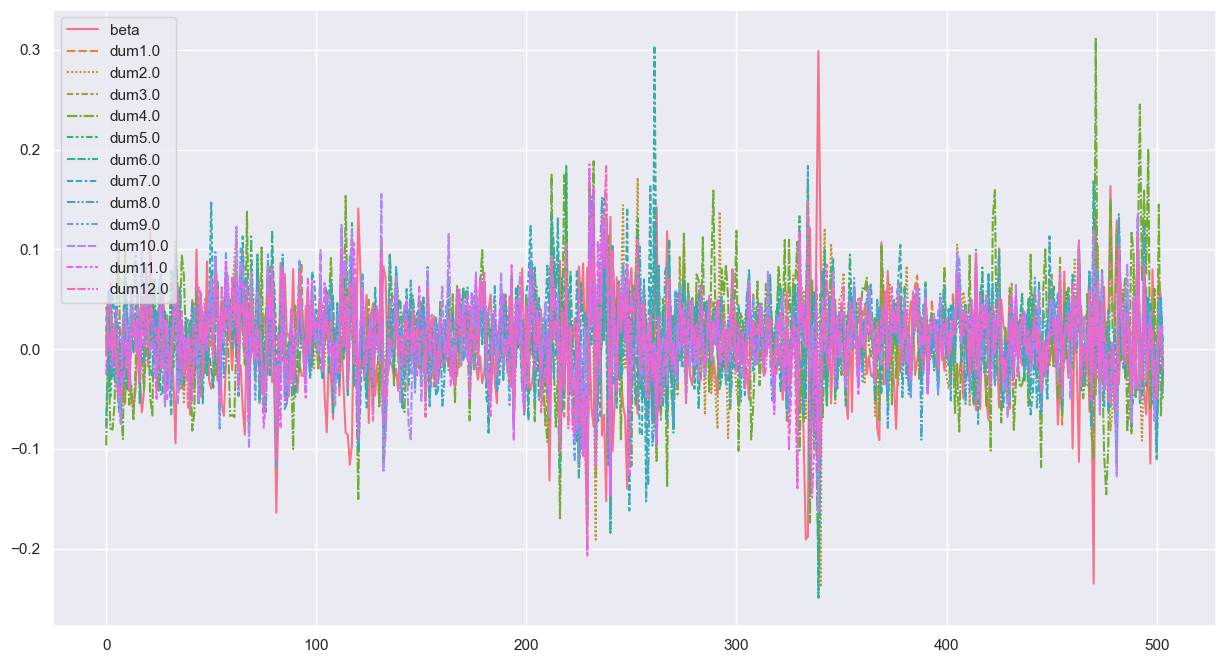

In [45]:
sns.lineplot(data=model2)
plt.show

In [46]:
model3=data1.groupby("date").apply(lambda x:sm.OLS(x['Rn_e'], x[['beta','dum1.0', 'dum2.0', 'dum3.0', 'dum4.0', 'dum5.0', 'dum6.0', 'dum7.0',
       'dum8.0', 'dum9.0', 'dum10.0', 'dum11.0', 'dum12.0']]).fit().tvalues).reset_index()

<function matplotlib.pyplot.show(close=None, block=None)>

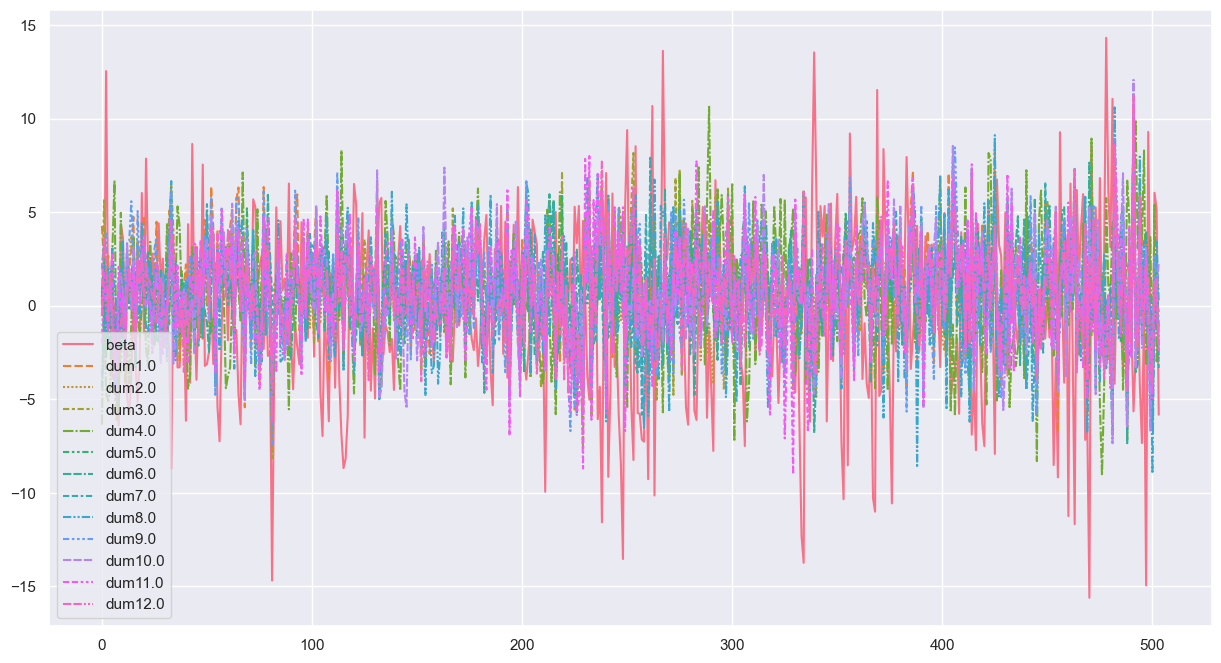

In [47]:
sns.lineplot(data=model3)
plt.show

In [48]:
avg_t_stat=model2.mean()
avg_t_stat

/var/folders/xm/v8rw_rk978q4m456yhl9rn_c0000gn/T/ipykernel_67435/4173865668.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  avg_t_stat=model2.mean()


beta      -0.001307
dum1.0     0.010281
dum2.0     0.009187
dum3.0     0.009002
dum4.0     0.008828
dum5.0     0.010638
dum6.0     0.011089
dum7.0     0.010386
dum8.0     0.008335
dum9.0     0.011276
dum10.0    0.010756
dum11.0    0.010216
dum12.0    0.009332
dtype: float64

In [49]:
avg_t_stat_abs=abs(model2[['beta','dum1.0', 'dum2.0', 'dum3.0', 'dum4.0', 'dum5.0', 'dum6.0', 'dum7.0',
       'dum8.0', 'dum9.0', 'dum10.0', 'dum11.0', 'dum12.0']]).mean()
avg_t_stat_abs

beta       0.035285
dum1.0     0.029537
dum2.0     0.036347
dum3.0     0.030291
dum4.0     0.046443
dum5.0     0.032273
dum6.0     0.032325
dum7.0     0.037039
dum8.0     0.034806
dum9.0     0.031737
dum10.0    0.033270
dum11.0    0.034256
dum12.0    0.030196
dtype: float64

 ## Compute Factor Exposures from Weights

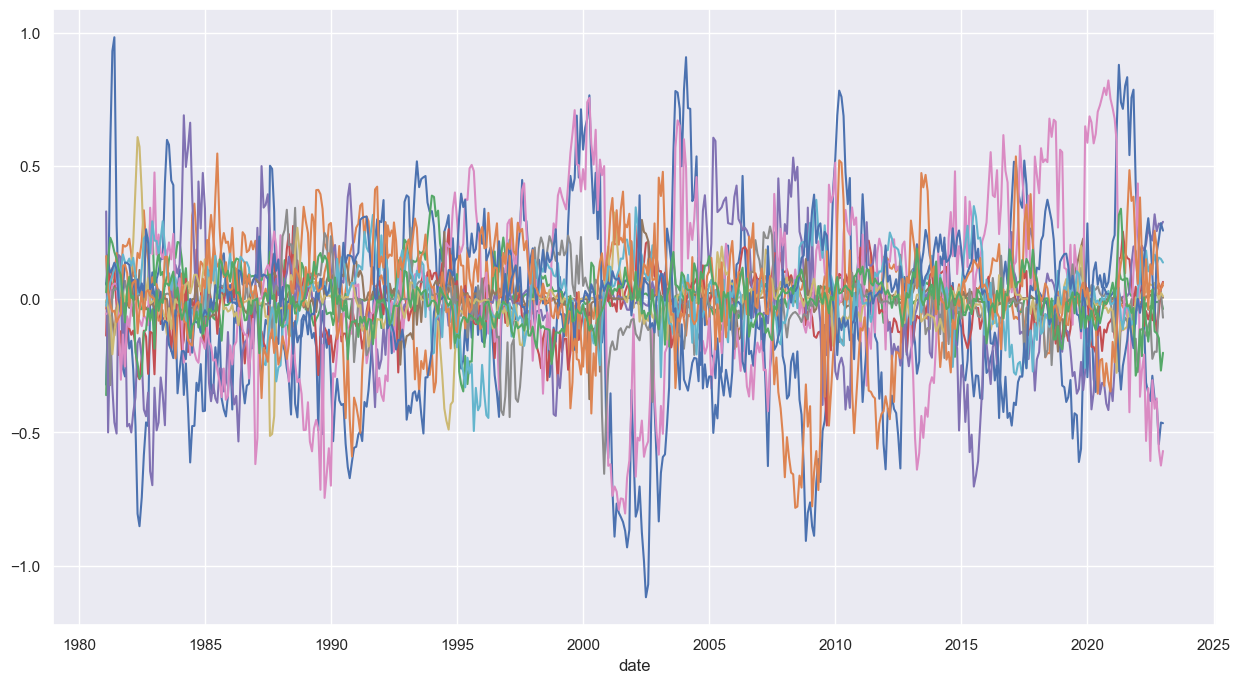

In [50]:
plt.show()
col=['beta','dum1.0','dum2.0','dum3.0','dum4.0','dum5.0','dum6.0','dum7.0','dum8.0','dum9.0','dum10.0','dum11.0','dum12.0']

for idx in col:
    sns.lineplot(data=data1.groupby('date').apply(lambda x: np.sum(x['wm_quant']*x[idx])))

In [51]:
v={}
for idx in col:
    v[idx]=abs(data1.groupby('date').apply(lambda x: np.sum(x['wm_quant']*x[idx]))).mean()

v

{'beta': 0.311227354642748,
 'dum1.0': 0.09071186626537596,
 'dum2.0': 0.05042060309424408,
 'dum3.0': 0.09088841667904264,
 'dum4.0': 0.1568146648405844,
 'dum5.0': 0.037284117619977436,
 'dum6.0': 0.26456536880721465,
 'dum7.0': 0.07655112330179477,
 'dum8.0': 0.05926417141528831,
 'dum9.0': 0.10753062751890505,
 'dum10.0': 0.13115887484255428,
 'dum11.0': 0.16252289380089696,
 'dum12.0': 0.06854757073513897}

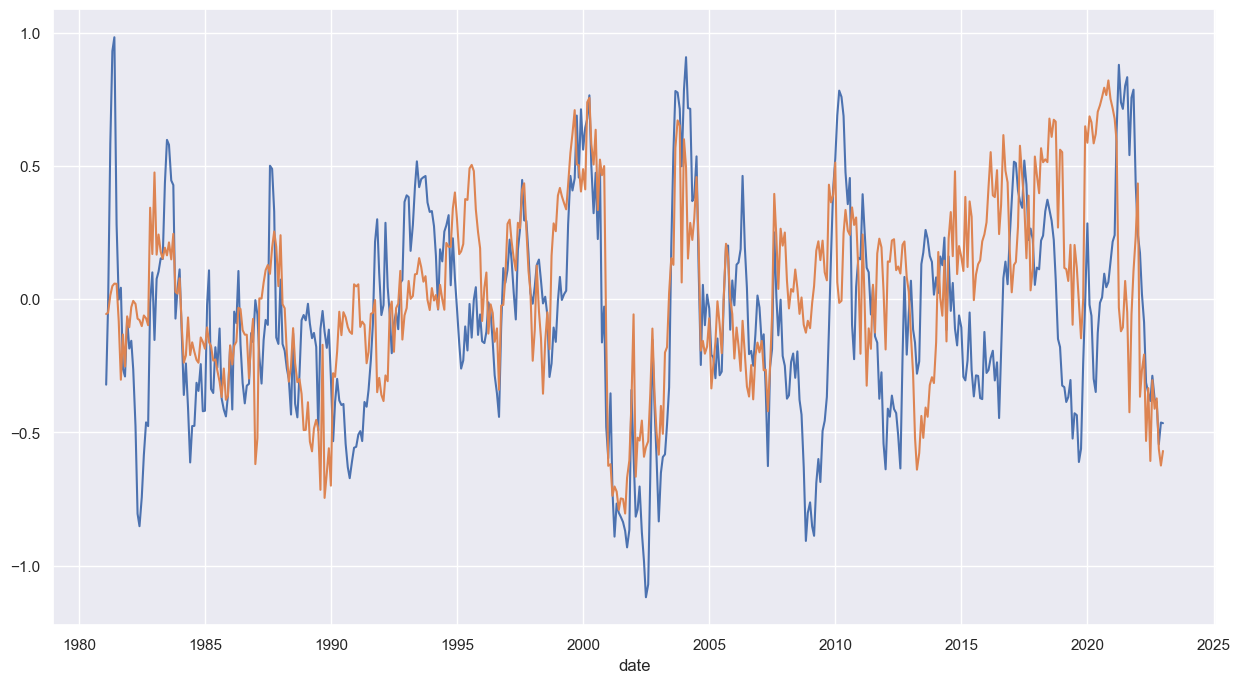

In [52]:
col1=['beta','dum6.0']
for idx in col1:
    sns.lineplot(data=data1.groupby('date').apply(lambda x: np.sum(x['wm_quant']*x[idx])))

In [76]:
exp=np.zeros((504,13))
for i,idx in enumerate(col):
    exp[:,i]=data1.groupby('date').apply(lambda x: np.sum(x['wm_quant']*x[idx]))
    
port=mom_ret['mom_ret'].values-(exp*data_reg.loc[:,'Rm':'Other']).apply(np.sum,axis=1)+exp.sum(axis=1)*data_reg['rf']

In [86]:
portdf=pd.DataFrame(port)
portdf.rename(columns={0:"port"},inplace=True)
portdf['date']=data_reg['date']
portdf.set_index('date',inplace=True)

<AxesSubplot:xlabel='date'>

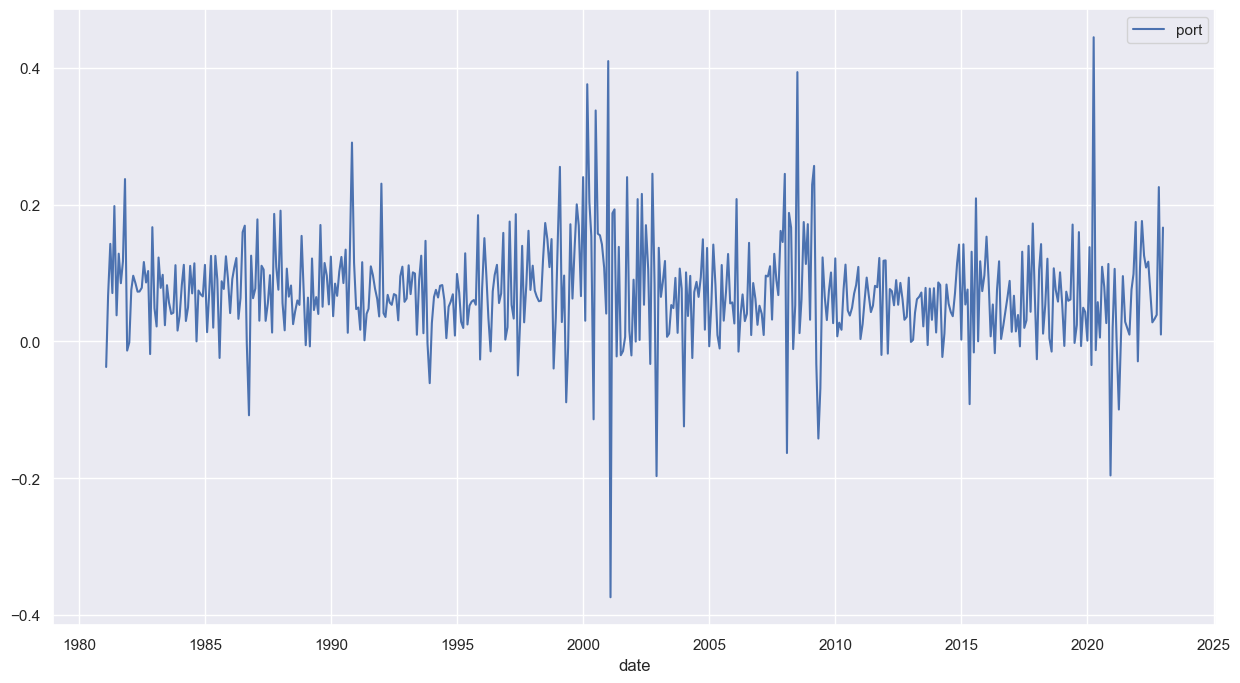

In [87]:
sns.lineplot(data=portdf)

/Users/matteoferrazzi/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

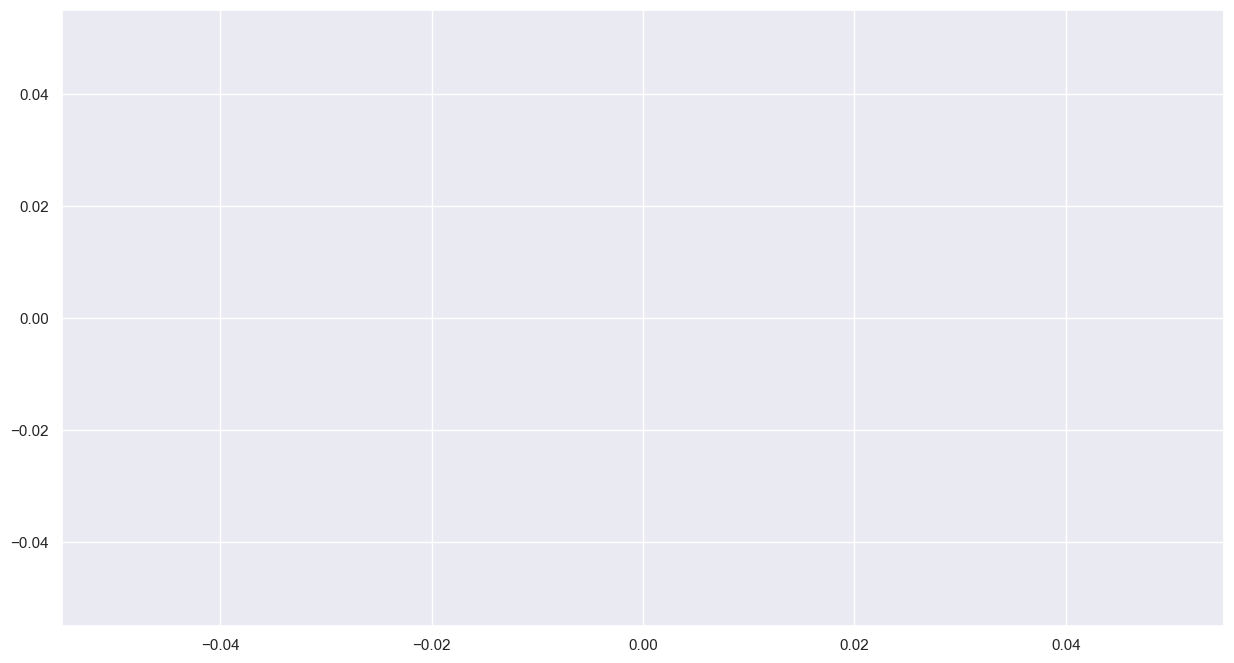